# Seizure detection sandbox

## Workspace Preparation

In [2]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
from kneed import KneeLocator

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
from os.path import join as ospj
from utils import *
import sys
from seizure_detection_pipeline_pre_train import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

sys.path.append('/users/wojemann/DSOSD/')
from DSOSD.model import NDD

2025-01-07 15:28:00.023762: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 15:28:01.460648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

In [4]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [5]:
set_seed(5210)

In [6]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP238'
montage = 'bipolar'

## Anomaly Detection

### Generating model predictions

In [7]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [8]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter_raw = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [9]:
inter_raw.columns

Index(['Fp02', 'LA01', 'LA02', 'LA03', 'LA04', 'LA05', 'LA06', 'LA07', 'LA08',
       'LA09',
       ...
       'LY02', 'LY03', 'LY04', 'LY05', 'LY06', 'LY07', 'LY08', 'LY10', 'LY11',
       'LY12'],
      dtype='object', length=131)

In [10]:
electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
if pt[:3] == 'CHO':
    suffix = ['CHOPR','CHOPM']
else:
    suffix = ['dkt','atropos']
electrode_localizations.name = clean_labels(electrode_localizations.name,pt) #don't end up using grey/white matter
electrode_regions.name = clean_labels(electrode_regions.name,pt)
electrode_localizations.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[1]}.pkl')) #don't end up using grey/white matter
electrode_regions.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[0]}.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter_raw.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter_neural = inter_raw[neural_channels]

In [11]:
electrode_regions

name        x        y        z index                          label  \
0    LA01  95.5355  129.152  60.4199    18                 left amygdala    
1    LA02  90.8723  128.736  59.7096    18                 left amygdala    
2    LA03  85.7008  128.294  59.0428     0                     EmptyLabel   
3    LA04  80.5413  127.366  58.2225     0                     EmptyLabel   
4    LA05  74.7366   128.18  56.9585     0                     EmptyLabel   
..    ...      ...      ...      ...   ...                            ...   
135  LY08  92.6567  174.071  94.8418     0                     EmptyLabel   
136  LY09  91.0054   173.69  99.1124     0   left rostral middle frontal    
137  LY10  88.8458  173.283  103.427     0   left rostral middle frontal    
138  LY11  86.6862  172.876  107.741  1027   left rostral middle frontal    
139  LY12  85.1361  172.184  112.959  1027   left rostral middle frontal    

                                   labels_sorted  \
0          [ left amygdala ,  left hippocampus ]   
1          [ left amygdala ,  left hippocampus ]   
2                                   [EmptyLabel]   
3                                   [EmptyLabel]   
4                                   [EmptyLabel]   
..                                           ...   
135                                 [EmptyLabel]   
136  [EmptyLabel,  left rostral middle frontal ]   
137  [EmptyLabel,  left rostral middle frontal ]   
138  [ left rostral middle frontal , EmptyLabel]   
139  [ left rostral middle frontal , EmptyLabel]   

                               percent_assigned  
0    [0.9696969697000001, 0.030303030300000002]  
1     [0.7575757576000001, 0.24242424240000002]  
2                                         [1.0]  
3                                         [1.0]  
4                                         [1.0]  
..                                          ...  
135                                       [1.0]  
136         [0.8787878788, 0.12121212120000001]  
137                [0.5757575758, 0.4242424242]  
138                  [0.696969697, 0.303030303]  
139                [0.8484848485, 0.1515151515]  

[140 rows x 8 columns]

In [12]:
# inter_neural.iloc[:,:22] = inter_neural.iloc[:,:22]*1e-3

In [13]:
inter_prep,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

In [14]:
# plot_iEEG_data(inter_prep,np.arange(len(inter_prep))/fs)

In [15]:
model= LTI(1,.5,128)
model.fit(inter_prep)

In [16]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [17]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=2:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    print(task)
    break

ictal294225


In [18]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# seizure_neural.loc[:,:22] = seizure_neural.iloc[:,:22]*1e-3
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [19]:
seizure_prep,fs = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=128)

In [20]:
len(seizure_prep)
print(len(seizure_prep),120*fs)

62975 15360


(<Figure size 8399.74x1380 with 1 Axes>, <Axes: xlabel='Time (s)'>)

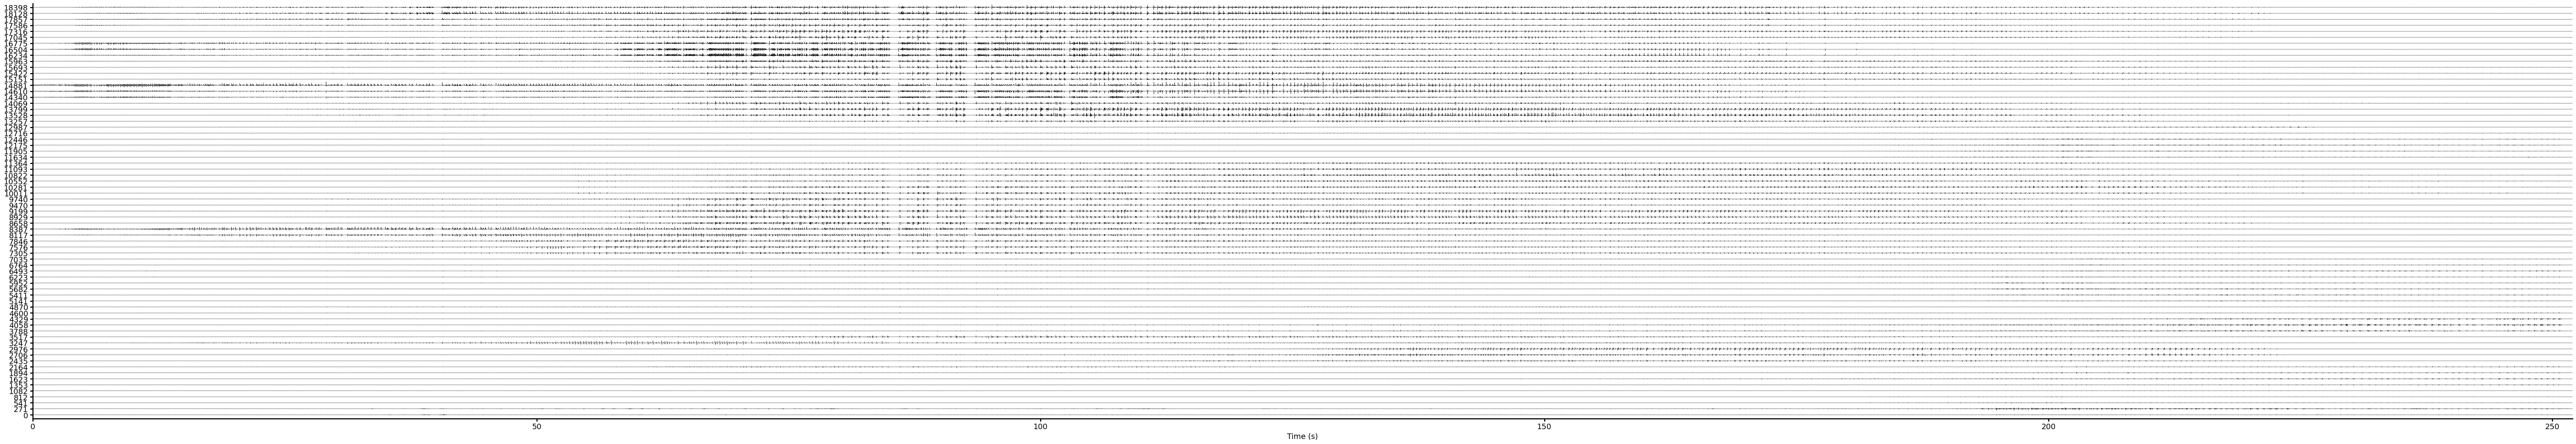

In [21]:
seizure_prep.max()
noisy_channel_mask = seizure_prep.abs().max() <= (np.median(seizure_prep.abs().max())*50)
seizure_prep.columns[~noisy_channel_mask]
seizure_slice = seizure_prep.loc[120*fs:len(seizure_prep)-(120*fs),:]
plot_iEEG_data(model.scaler.transform(seizure_slice)[:,noisy_channel_mask],np.arange(len(seizure_slice))/fs)

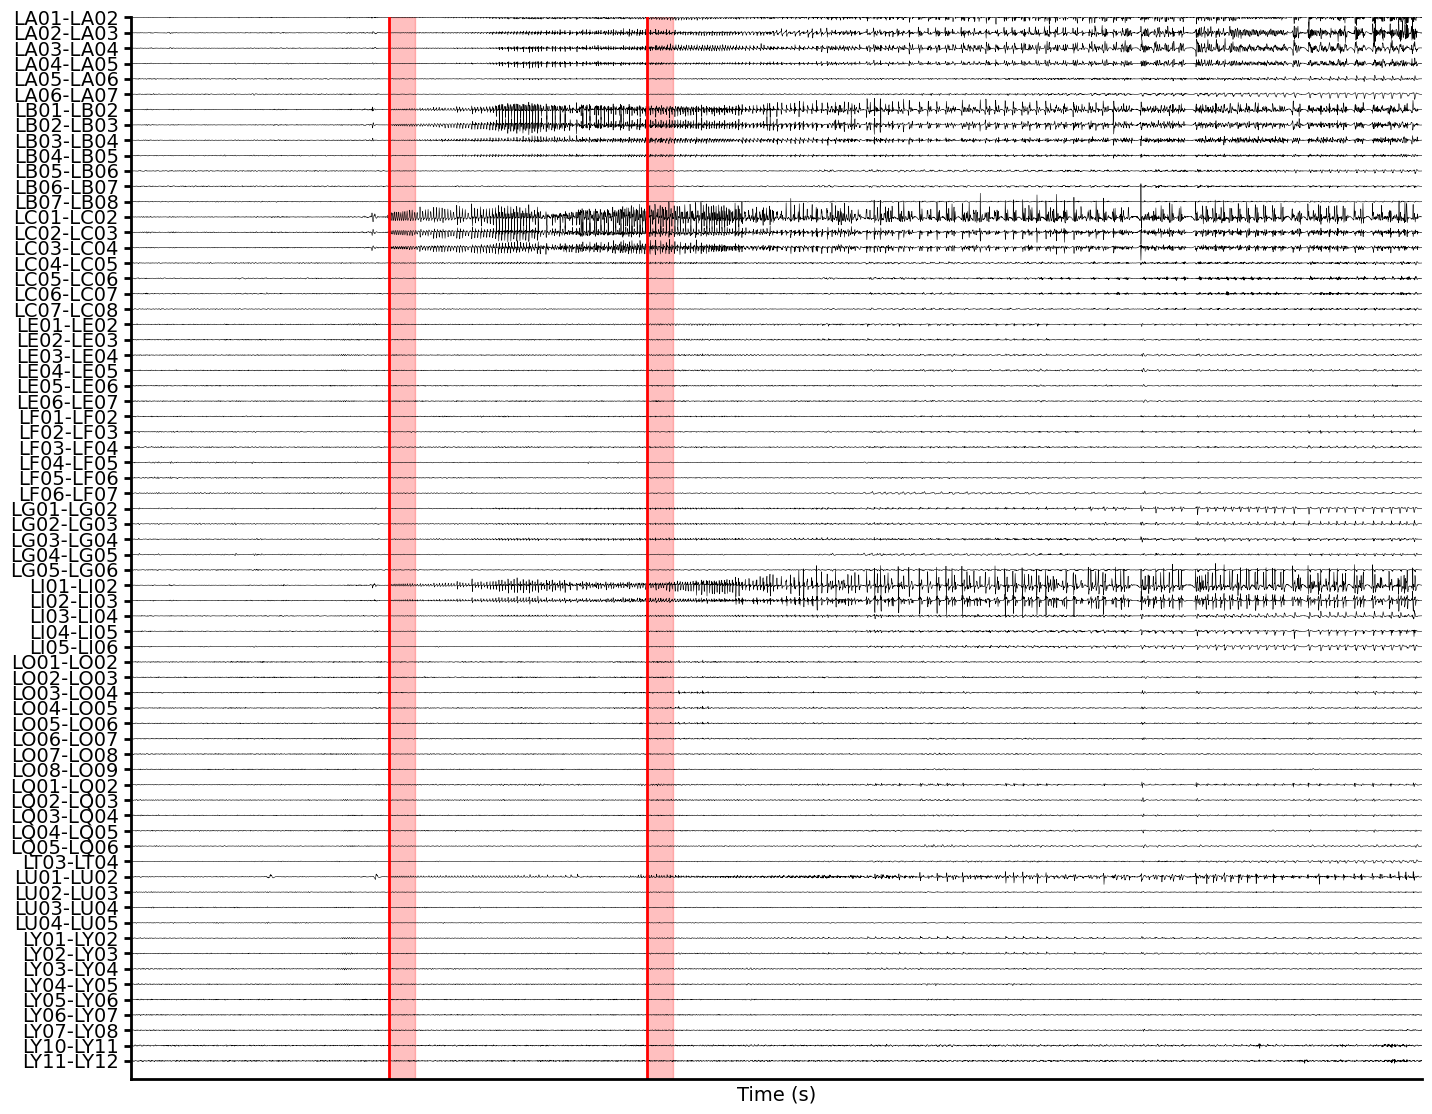

In [22]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 110) & (plot_time < 160)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds])
plt.axvline(120,color='red')
plt.axvline(130,color='red')
plt.axvspan(120,121,color='red',alpha=0.25)
plt.axvspan(130,131,color='red',alpha=0.25)
plt.xticks([])
plt.savefig(ospj(figpath,'example_seizure_just_onset.pdf'))

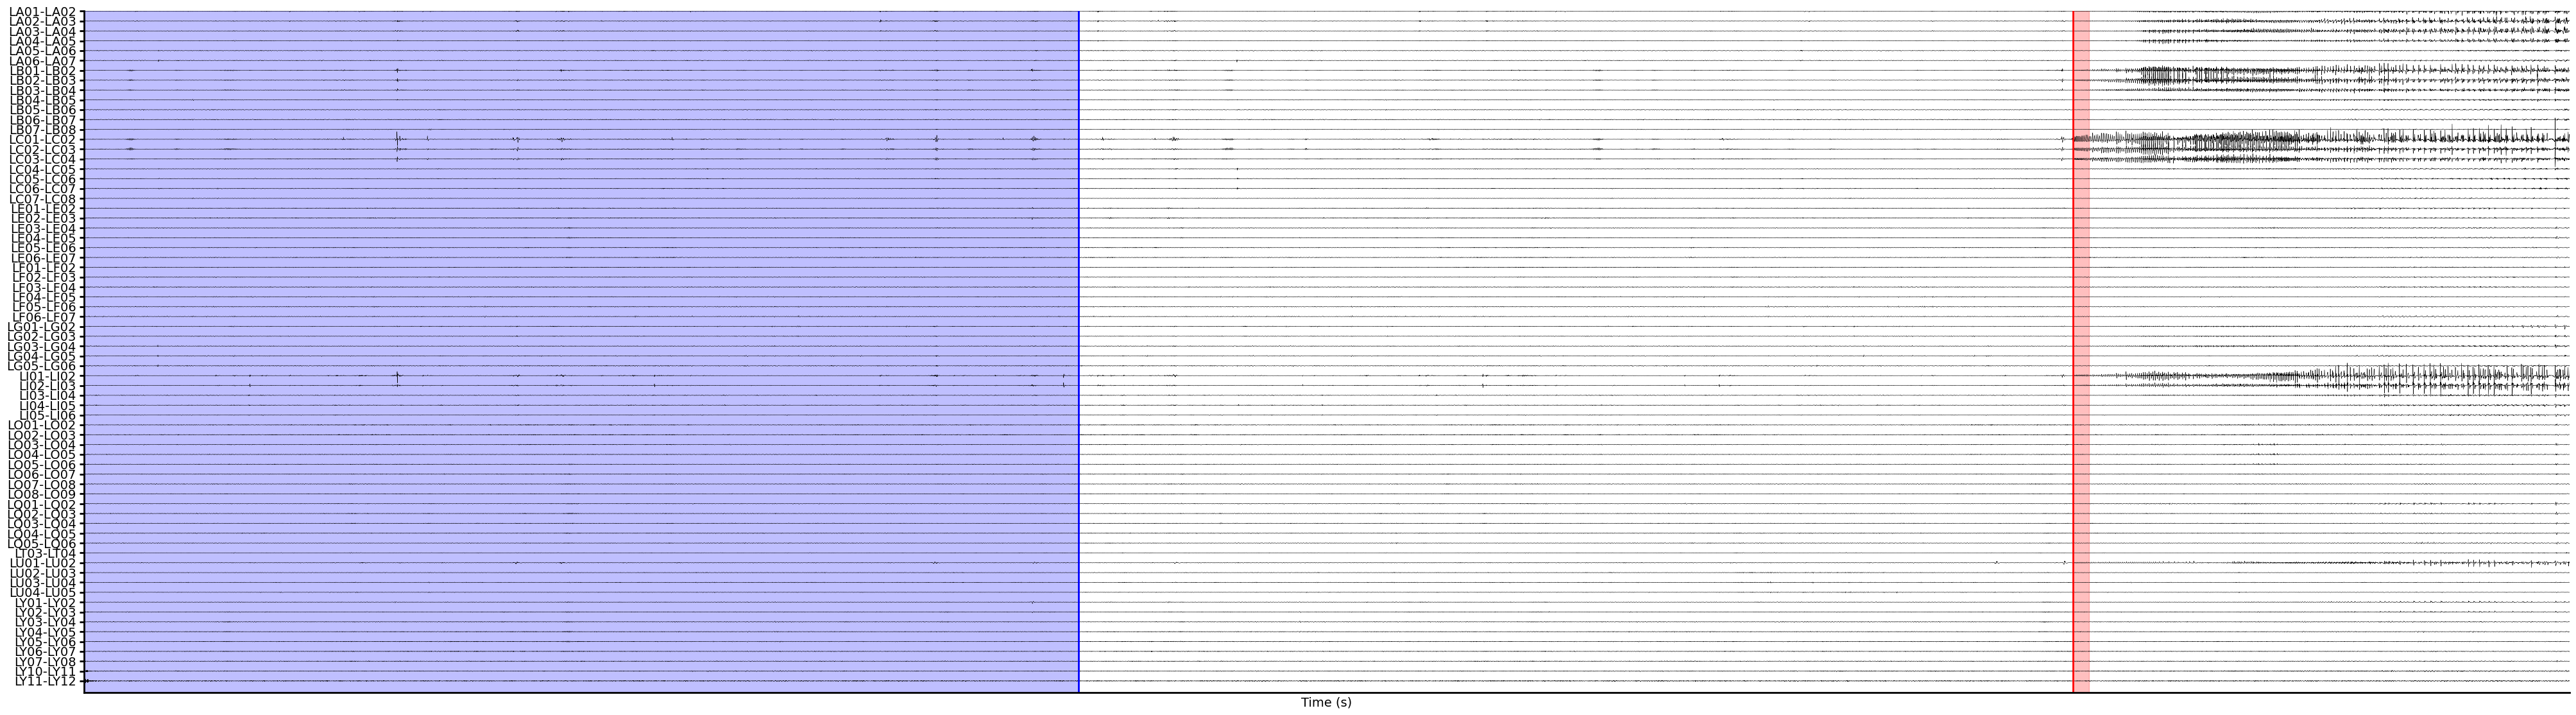

In [23]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 0) & (plot_time < 150)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds])
plt.axvline(0,color='blue')
plt.axvline(60,color='blue')
plt.axvspan(0,60,color='blue',alpha=0.25)
plt.axvline(120,color='red')
# plt.axvline(130,color='red')
plt.axvspan(120,121,color='red',alpha=0.25)
# plt.axvspan(130,131,color='red',alpha=0.25)
plt.xticks([])
plt.savefig(ospj(figpath,'example_seizure_onset.pdf'))

In [24]:
model.fit(seizure_prep.loc[:fs*60,:])

In [25]:
preds = model(seizure_prep)
preds_reject = preds[noisy_channel_mask,:]
preds_smooth = sc.ndimage.uniform_filter1d(preds_reject,20,axis=1)

([], [])

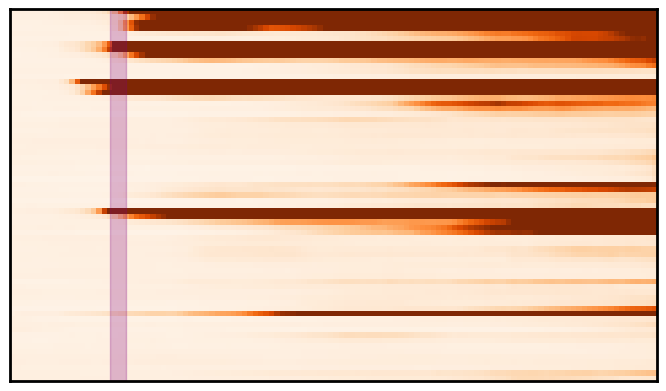

In [26]:
times = model.get_times(seizure_prep)
time_mask = (times > 110) & (times < 170)
plt.matshow(preds_smooth[:,time_mask],cmap='Oranges')
plt.clim([0,10])
tiks = np.arange(0,preds_smooth.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(times-10))
plt.axvspan(span_start,span_start+3,alpha=0.25,color='Purple')
plt.xticks([])
plt.yticks([])

([], [])

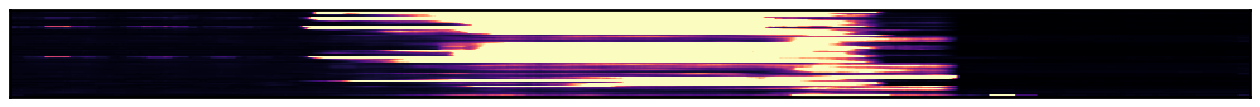

In [40]:
plt.matshow(preds_smooth,interpolation='none')
plt.clim([0,10])
plt.xticks([])
plt.yticks([])

In [27]:
ch_mask_early = np.zeros_like(preds_smooth)
ch_mask_late = np.zeros_like(preds_smooth)
ch_mask_all = np.zeros_like(preds_smooth)
early = np.sum(preds_smooth[:,:118] > .2,axis=1) > 30
late = np.sum(preds_smooth[:,-118:] > .2,axis=1) > 30
all_mask = np.sum(preds_smooth > 0.75,axis=1) > preds_smooth.shape[1]/2
ch_mask_early[early,:] = 1
ch_mask_late[late,:] = 1
ch_mask_all[all_mask,:] = 1
# plt.imshow(ch_mask_early)
# plt.figure()
# plt.imshow(ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_early + ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_all)

In [28]:
# print(seizure_prep.columns[noisy_channel_mask][early])
# print(seizure_prep.columns[noisy_channel_mask][late])

In [29]:
# time_mask = (times > 120) & (times < (max(times)-120))
# preds_smooth_reject = preds_smooth[~late,:]
# plt.imshow(preds_smooth_reject[:,time_mask])
# plt.clim(0,100)
# plt.yticks([])
# plt.xticks([])

In [30]:
# onset_chs_list = []
# for t in np.arange(0,1,.01):
#     late = np.sum(preds_smooth[:,-118:] > t,axis=1) > 30
#     preds_smooth_reject = preds_smooth[~late,:]
#     onset_ch_idxs = np.all(preds_smooth_reject[:,118:123]>t,axis=1)
#     sz_chs = seizure_prep.columns[~late]
#     onset_chs = sz_chs[onset_ch_idxs]
#     onset_chs_list.append(onset_chs)

### Unsupervised classification

#### Knee

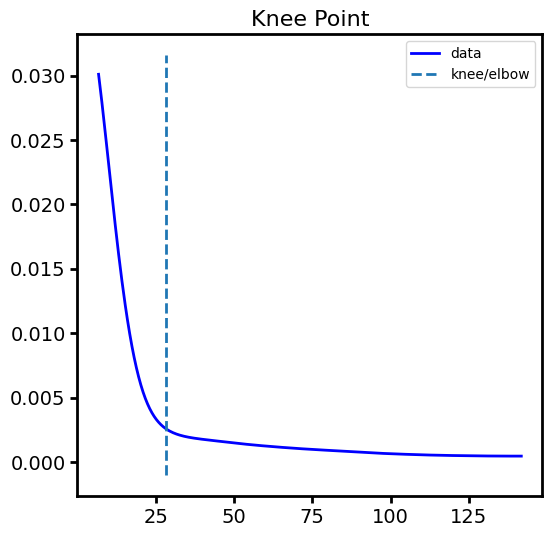

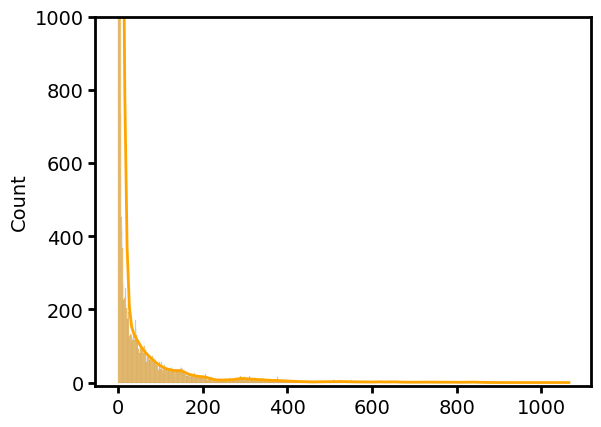

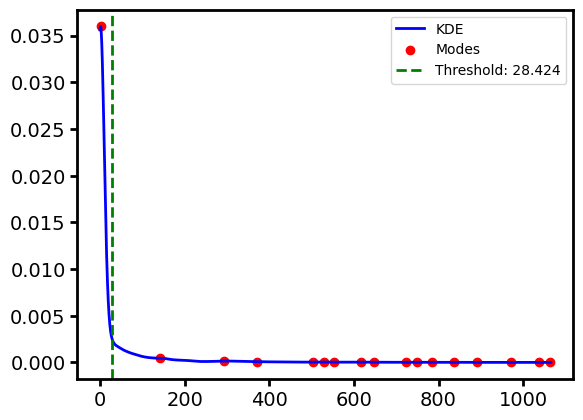

In [64]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
ch_reject = np.zeros((preds_smooth.shape[0],1),dtype=bool)
ch_thresholds = np.zeros((preds_smooth.shape[0],1))
# for ch in range(preds_smooth.shape[0]):
    # Example: Seizing probabilities
# probabilities = preds_smooth[:,240:-240].flatten()
probabilities = preds_smooth.flatten()
probabilities = probabilities[probabilities < np.percentile(probabilities,99.99)]
# KDE using scipy's gaussian_kde
kde = gaussian_kde(probabilities,'scott')

# Define an x-axis range to evaluate the KDE
x_vals = np.linspace(min(probabilities), max(probabilities), 3000)
kde_vals = kde(x_vals)

# Find peaks (modes) in the KDE
peaks, _ = find_peaks(kde_vals)

# Find troughs (local minima) between peaks
try:
    biggest_pk_idx = np.where(kde_vals[peaks]>(np.mean(kde_vals)+np.std(kde_vals)))[0][-1]
except:
    biggest_pk_idx = np.argmax(kde_vals[peaks])
# biggest_pk_idx = np.argmax(kde_vals[peaks])
start, end = peaks[biggest_pk_idx], peaks[biggest_pk_idx+1]
trough_idx = np.argmin(kde_vals[start:end]) + start
# trough_idx = int((end-start)/2 + start)
# trough_idx = np.argmin(fit_mdl(x_vals))
# threshold = x_vals[int(trough_idx)]

kneedle = KneeLocator(x_vals[start+15:end],kde_vals[start+15:end],
                      curve='convex',direction='decreasing',interp_method='polynomial')
kneedle.plot_knee()
threshold = kneedle.knee
# print(f"{seizure_prep.columns[ch]} Threshold between modes: {threshold}")
plt.figure()
# # Plot the results
sns.histplot(probabilities,color='orange',bins=1000,kde=True)
plt.ylim([-10,1000])
plt.figure()
plt.plot(x_vals, kde_vals, label="KDE",color='blue')
plt.scatter(x_vals[peaks], kde_vals[peaks], color='red', label="Modes")
# plt.scatter(x_vals[trough_idx], kde_vals[trough_idx], color='green', label="Knee (Threshold)")
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.3f}')
plt.legend()
plt.show()

In [65]:
print(np.mean(kde_vals),np.var(kde_vals))

0.000613032988194444 1.1656874841344283e-05


([], [])

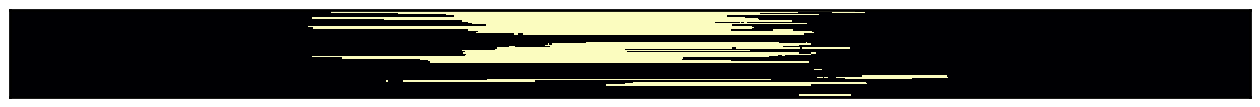

In [66]:
plt.matshow(preds_smooth[:,:]>threshold,interpolation='none')
plt.yticks([])
plt.xticks([])

### Gamma

In [34]:
from scipy.stats import gamma

# Step 1: Fit Gamma distribution to interictal data
def fit_gamma(interictal_data):
    shape, _, scale = gamma.fit(interictal_data, floc=0)  # force location to 0
    return shape, scale

# Step 2: Calculate the confidence value for a given loss
def confidence_outside_distribution(loss_value, shape, scale):
    # Calculate the CDF for the given loss value
    cdf_value = gamma.cdf(loss_value, a=shape, scale=scale)
    
    # Confidence value that the loss is outside the interictal distribution
    confidence_outside = cdf_value
    return confidence_outside

def get_95_confidence_threshold(shape, scale):
    # Get the loss value at the 95th percentile using the PPF (percent point function)
    threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
    return threshold_value
 
# Example usage
loss_value = preds_smooth[:,:-240] # Example new loss value

# Fit Gamma distribution to interictal data
shape, scale = fit_gamma(loss_value)

# Calculate the confidence for the given loss value
confidence = confidence_outside_distribution(preds_smooth, shape, scale)

# print(f"Confidence that the loss value {loss_value} is outside the interictal distribution: {confidence:.4f}")

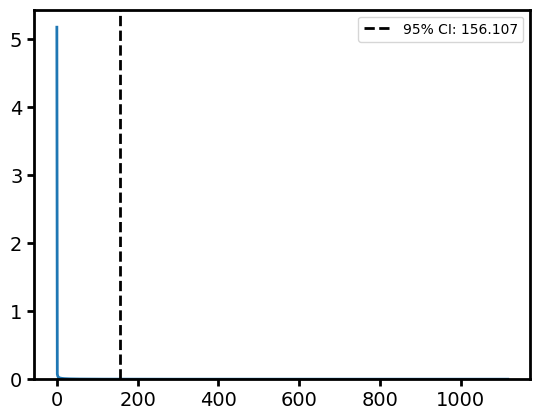

In [35]:
x_plot = np.linspace(np.min(preds_smooth),np.max(preds_smooth),1000)
plotting_pdf = sc.stats.gamma.pdf(x_plot,a=shape,scale=scale)
plt.plot(x_plot,plotting_pdf);
plt.hist(preds_smooth.flatten(),density=True,bins=1000);
thresh = sc.stats.gamma.ppf(0.95,a=shape,scale=scale)
plt.axvline(thresh,color='k',linestyle='--',label=f'95% CI: {np.round(thresh,3)}');
plt.legend()
# plt.figure()
# plt.plot(loss_value.T)

([], [])

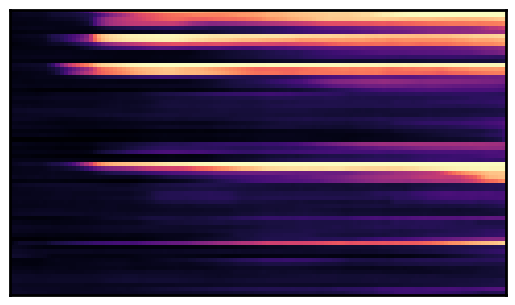

In [36]:
plt.imshow(confidence.reshape(preds_smooth.shape)[:,time_mask])
plt.yticks([])
plt.xticks([])

([], [])

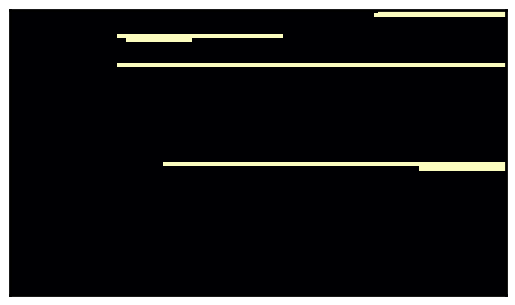

In [37]:
plt.imshow(confidence.reshape(preds_smooth.shape)[:,time_mask]>0.95)
plt.yticks([])
plt.xticks([])

In [38]:
threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
threshold_value

156.1073453441415

### Measuring dynamic spread

In [39]:
# First seizing index at the final threshold after offset
# UEO channels at first seizing index + 3 indices
# Seizing index and time since first seizing index for each channel
seizure_nart = seizure_prep.loc[:,noisy_channel_mask]
time_wins = model.get_times(seizure_nart)
sz_chs = seizure_nart.columns
t = threshold
first_sz_idx_offset = 240
sz_clf_final = preds_smooth > t
# Get channels
sliced_data = sz_clf_final[:,first_sz_idx_offset:]
df = pd.DataFrame(sliced_data).T
seizing = df.rolling(window=3,closed='right').apply(lambda x: (x == 1).all())
first_sz_idxs = seizing.idxmax().to_numpy() - 2
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
if sum(seized_idxs) > 0:
    sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
    sz_times_arr -= np.min(sz_times_arr)
    sz_ch_arr = sz_chs[seized_idxs]
    sz_ch_arr = np.array([s.split("-")[0] for s in sz_ch_arr]).flatten()
else:
    sz_ch_arr = []
    sz_times_arr = []

In [40]:
time_wins[first_sz_idxs[seized_idxs]]

array([126.9921875, 137.4921875, 141.4921875, 171.4921875, 177.9921875,
       180.4921875, 120.9921875, 120.9921875, 169.9921875, 183.4921875,
       183.9921875, 185.4921875, 206.9921875, 120.9921875, 123.9921875,
       124.4921875, 183.9921875, 189.9921875, 189.4921875, 215.9921875,
       256.9921875, 242.4921875, 241.9921875, 236.9921875, 322.4921875,
       198.9921875, 183.4921875, 184.4921875, 182.9921875, 184.9921875,
       183.9921875, 121.4921875, 136.4921875, 165.4921875, 167.4921875,
       170.9921875, 336.4921875, 195.4921875, 164.4921875, 249.9921875,
       247.4921875, 251.9921875, 317.9921875])

In [41]:
idxs = np.argsort(sz_times_arr)
print(sz_ch_arr[idxs])

['LB01' 'LB02' 'LC01' 'LI01' 'LC02' 'LC03' 'LA01' 'LI02' 'LA02' 'LA03'
 'LU01' 'LI03' 'LI04' 'LB03' 'LI05' 'LA04' 'LA05' 'LA06' 'LG03' 'LB04'
 'LG01' 'LB05' 'LC04' 'LG05' 'LG02' 'LG04' 'LB06' 'LC06' 'LC05' 'LT03'
 'LF06' 'LB07' 'LC07' 'LF04' 'LF03' 'LF02' 'LU03' 'LU02' 'LU04' 'LF01'
 'LY10' 'LF05' 'LQ04']


Text(0.5, 1.0, 'Seizure spread after onset')

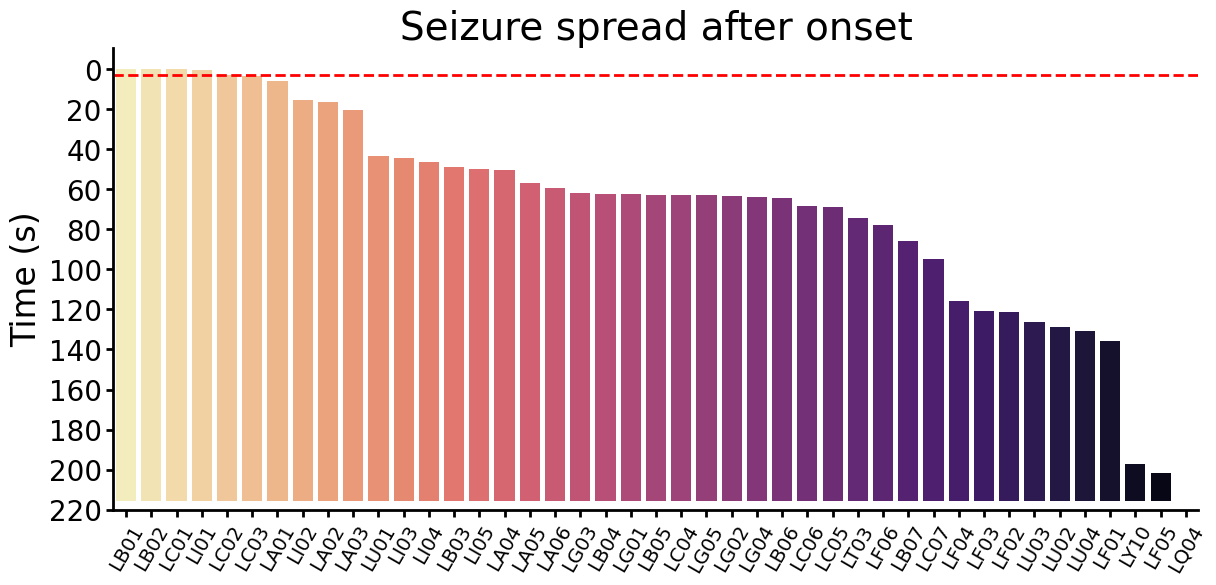

In [42]:
plt.figure(figsize=(14,6))
# plt.bar(np.arange(len(idxs)),sz_times_arr[idxs],color='green')
plot_times_arr = max(sz_times_arr) - sz_times_arr
sns.barplot(x=np.arange(len(idxs)),y=plot_times_arr[idxs],palette='magma_r',orient='v')
sns.despine()
plt.xticks(np.arange(len(idxs)),sz_ch_arr[idxs],rotation=60)
t = plt.yticks()
y_tix = max(sz_times_arr) - np.arange(0,221,20)
plt.yticks(y_tix,np.arange(0,221,20),fontsize=20)
plt.axhline(max(sz_times_arr)-3,ls='--',color='red',linewidth=2)
# plt.axhline(max(sz_times_arr)-10,ls='--',color='blue',linewidth=2)
plt.ylabel("Time (s)",fontsize=24)
plt.title('Seizure spread after onset',fontsize=28)

In [43]:
vals,vecs = sc.linalg.eig(model.model.coef_)

<StemContainer object of 3 artists>

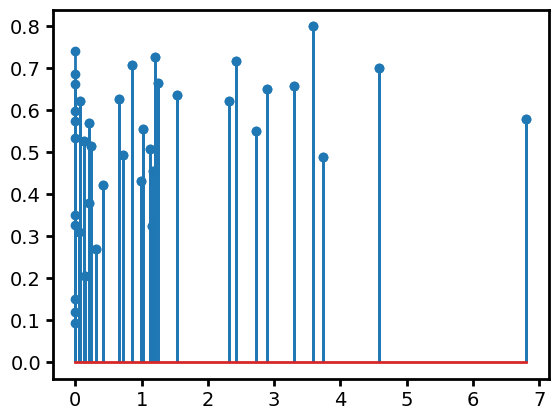

In [44]:
freqs = np.abs(np.imag(vals))*fs/(2*np.pi)
mags = np.abs(np.real(vals))
plt.stem(freqs,mags)

## Deep Learning

In [45]:
 # Instantiate the model
input_size = inter_prep.shape[1]
hidden_size = 10

# Check for cuda
# ccheck = torch.cuda.is_available()
ccheck = False

# Initialize the model
model = LSTMModel(input_size, hidden_size)

# Scale the training data
model.fit_scaler(inter_prep)
inter_z = model.scaler_transform(inter_prep)
inter_z = pd.DataFrame(inter_z,columns=inter_prep.columns)

# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter_z,fs=fs)

dataset = TensorDataset(input_data, target_data)
full_batch = len(dataset)
dataloader = DataLoader(dataset, batch_size=full_batch, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model, this will just modify the model object, no returns
# print("Training patient specific model")
train_model(model,dataloader,criterion,optimizer,ccheck=ccheck,num_epochs=10)

# Creating classification thresholds
input_data,target_data = prepare_segment(inter_z,fs=fs)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=full_batch,ccheck=ccheck)
thresholds = np.percentile(inter_outputs,85,0)

In [46]:
seizure_z = model.scaler_transform(seizure_prep)
seizure_z = pd.DataFrame(seizure_z,columns=seizure_prep.columns)
input_data, target_data,time_wins = prepare_segment(seizure_z,fs,12,1,ret_time=True)
# Generate seizure detection predictions for each window
outputs = predict_sz(model,input_data,target_data,batch_size=len(input_data)//2,ccheck=ccheck)
seizure_mat = repair_data(outputs,seizure_z,fs=fs)
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.sqrt(seizure_mat),1).T
# Creating classifications
# mdl_outs = (raw_sz_vals.T > np.log(thresholds)).T.astype(float)

([], [])

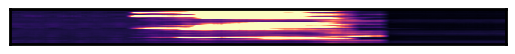

In [47]:
plt.figure()
smooth_sz_vals = sc.ndimage.uniform_filter1d(raw_sz_vals,20,axis=1)
plt.imshow(smooth_sz_vals)
plt.clim((0,5))
plt.xticks([])
plt.yticks([])

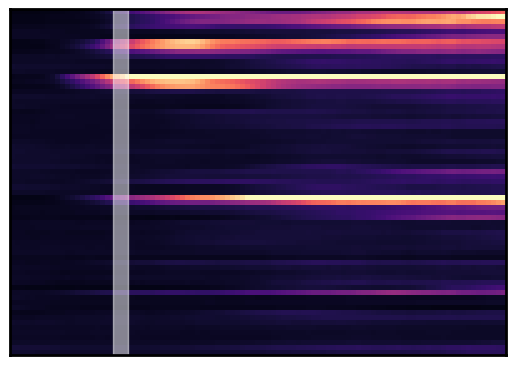

In [48]:
time_mask = (time_wins > 110) & (time_wins < 160)
plt.imshow(smooth_sz_vals[:,time_mask],cmap='magma')
plt.clim([0,10])
tiks = np.arange(0,smooth_sz_vals.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(time_wins-10))
plt.axvspan(span_start,span_start+3,alpha=0.5,color='white')
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_seizure_just_onset_detection.pdf'))

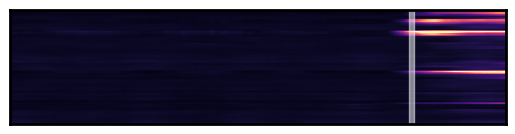

In [49]:
time_mask = (time_wins > 0) & (time_wins < 150)
plt.imshow(smooth_sz_vals[:,time_mask],cmap='magma')
plt.clim([0,10])
tiks = np.arange(0,smooth_sz_vals.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(time_wins-120))
plt.axvspan(span_start,span_start+3,alpha=0.5,color='White')
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_seizure_onset_detection.pdf'))

In [50]:
# plt.figure()
# plt.imshow(np.median(seizure_mat,1).T)
# plt.figure()
# temp = np.exp(np.mean(seizure_mat,1).T)
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.mean(np.exp(seizure_mat),1).T
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.exp(np.percentile(seizure_mat,75,axis=1).T)
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.percentile(np.exp(seizure_mat),75,axis=1).T
# plt.imshow(temp/np.max(temp))
# plt.colorbar()

## DSOSD Package

In [53]:
model = NDD(fs=128)
model.fit(seizure_prep.loc[:fs*120/2,:])

# generate seizure likelihood feature (NDD)
sz_prob = model(seizure_prep)
sz_prob_times = model.get_win_times(len(seizure_prep))

In [55]:
model.get_threshold(sz_prob)

2.451684263519006

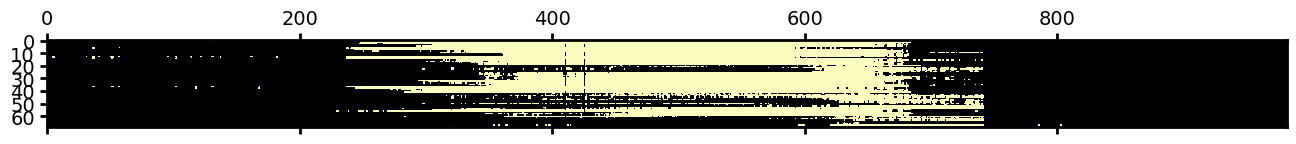

In [59]:
plt.matshow(sz_prob.T > model.threshold)

In [60]:
sz_spread = model.get_onset_and_spread(sz_prob)

In [61]:
sz_spread

LI01-LI02  LC02-LC03  LC01-LC02  LC03-LC04  LB02-LB03  LB01-LB02  \
0        236        236        236        236        237        238   

   LB03-LB04  LI02-LI03  LA01-LA02  LA04-LA05  ...  LQ03-LQ04  LO05-LO06  \
0        242        243        243        246  ...        608        612   

   LE05-LE06  LY10-LY11  LY02-LY03  LO07-LO08  LO08-LO09  LY07-LY08  \
0        613        619        622        624        627        628   

   LY04-LY05  LQ02-LQ03  
0        638        729  

[1 rows x 66 columns]

In [63]:
sz_prob_times[sz_spread - np.min(np.min(sz_spread))]

array([[  0. ,   0. ,   0. ,   0. ,   0.5,   1. ,   3. ,   3.5,   3.5,
          5. ,   5. ,   5.5,  10. ,  19.5,  23. ,  25.5,  28. ,  28.5,
         32. ,  32. ,  34. ,  34. ,  37. ,  41.5,  41.5,  43. ,  46.5,
         48.5,  50. ,  51.5,  52.5,  53. ,  54. ,  54.5,  55. ,  55. ,
         55. ,  56. ,  61.5,  62. ,  62.5,  66. ,  66.5,  67. ,  78.5,
        101. , 102.5, 105.5, 105.5, 110. , 124.5, 147. , 174.5, 179.5,
        184.5, 184.5, 186. , 188. , 188.5, 191.5, 193. , 194. , 195.5,
        196. , 201. , 246.5]])